# Cài đặt và import các thư viện cần thiết

In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e93d81jw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e93d81jw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
# Set-up SSIM Loss
!pip install pytorch-msssim

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import cv2
from datasets import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Chia dataset để training model

## Chia dataset cho tập train

In [5]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/train/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", train_images_np.shape)


Kích thước của mảng hình ảnh: (1177, 256, 256, 3)


In [6]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/train/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", train_labels_np.shape)

Kích thước của mảng mặt nạ: (1177, 256, 256)


In [7]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in train_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in train_labels_np],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(dataset_dict)

In [8]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1177
})

## Chia dataset cho tập validation

In [9]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/validation/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", val_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [10]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/validation/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", val_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [11]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in val_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in val_labels_np],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(dataset_dict)

In [12]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

## Chia dataset cho tập test

In [13]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/test/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", test_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [14]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/test/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", test_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [15]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in test_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in test_labels_np],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(dataset_dict)

In [16]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

# Kiểm tra ảnh và mặt nạ

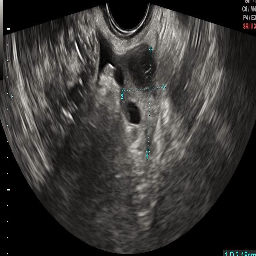

In [17]:
img_num = random.randint(0, train_images_np.shape[0]-1)
example = train_dataset[img_num]
image = example["image"]
image

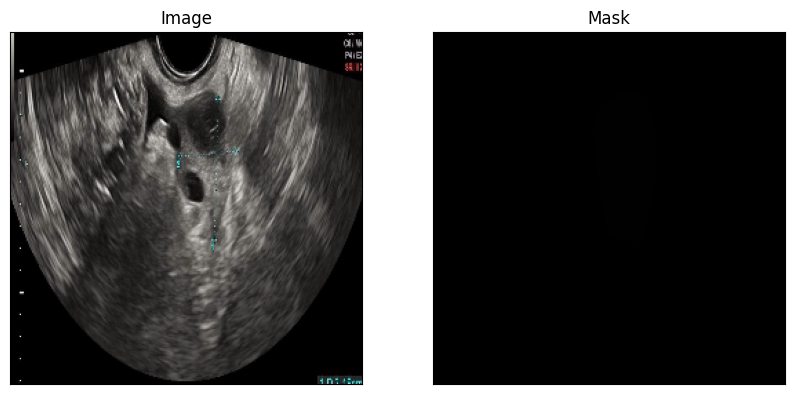

In [18]:
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

(-0.5, 255.5, 255.5, -0.5)

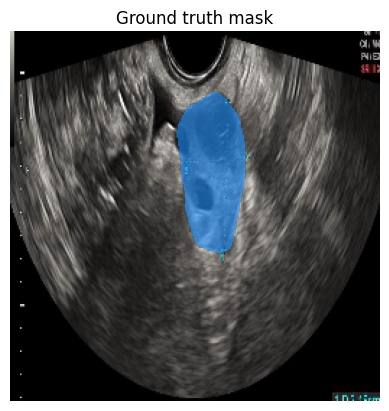

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Vẽ bounding boxes cho mặt nạ

In [20]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# Training Model

## Hàm tạo 1 dataset input images and mask

In [21]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt | vẽ box cho mặt nạ
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model | Chuẩn bị mặt nạ và hộp giới hạn
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default | Loại bỏ chiều Batch được thêm vào mặc định
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation | Thêm ground truth để đánh giá việc Segment sau này, đánh giá hiệu suất mô hình
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

## Load model SAM

### Xử lý dữ liệu để tương thích với đầu vào Model

In [22]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-04-24 10:30:20.128813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 10:30:20.128921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 10:30:20.255730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [23]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
test_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [24]:
example = train_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [25]:
example = val_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [26]:
example = test_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [27]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=False)

In [28]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [29]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [30]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [31]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load model Pretrained của Segment Anything

In [32]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

### Khởi tạo model với hàm tối ưu là Adam, hàm loss là DiceCELoss

In [33]:
import torch.optim as optim
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)

# Sử dụng DiceCELoss
diceCE_loss = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Sử dụng DiceFocalLoss
# diceFocal_loss = DiceFocalLoss(sigmoid=True, gamma=0.25)

# Sử dụng DiceLoss
# seg_loss = DiceLoss(to_onehot_y=True, softmax=True)



## Xây dựng Hàm Joint Loss

### Hàm Focal_Loss

In [34]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.

# pyre-strict

import torch
from torch.nn import functional as F


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

### Load hàm loss đánh giá model

In [35]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

smooth=1e-10
gamma = 2
weight = None

# Define functions for calculating evaluation metrics
def dice(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    false_positive = torch.sum(predicted) - true_positive
    return (2. * true_positive + smooth) / (2. *true_positive + false_negative + false_positive + smooth)

def iou(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    return (intersection + smooth) / (union + smooth)

def recall(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    return (true_positive + smooth) / (true_positive + false_negative + smooth)

def precision(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted) - true_positive
    return (true_positive + smooth) / (true_positive + false_positive + smooth)

def ssim(predicted, target):
    ssim_module = SSIM(data_range=255, size_average=True, channel=1)
    ssim_loss = 1 - ssim_module(predicted, target)
    return ssim_loss
    
def focalLoss(predicted, target):
    logpt = F.log_softmax(predicted, dim=1)
    pt = torch.exp(logpt)
    logpt = (1-pt)**gamma * logpt
    loss = F.nll_loss(logpt, target, weight)
    return loss

def jointLoss(predicted, target):
    loss = (1 - iou(predicted, target) + sigmoid_focal_loss(inputs = predicted, targets = target, alpha = 0.25, gamma = 2, reduction = "none",) + ssim(predicted, target))/3
    return loss

### Train Model

### Early Stopping

In [36]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint
checkpoint_dir = '/kaggle/working/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Add list to record loss of train dataset
train_loss_list = []
train_dice_loss = []
train_iou_loss = []
train_precision_loss = []
train_recall_loss = []

# Add list to record loss of validation dataset
val_loss_list = []
val_dice_loss = []
val_iou_loss = []
val_precision_loss = []
val_recall_loss = []

# Early stopping parameters
patience = 10  # Số lượng epochs mà mô hình không cải thiện trước khi dừng sớm
counter = 0

# Training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    
    # Train Model on Train Dataset
    epoch_losses = []
    train_dice_scores = []
    train_iou_scores = []
    train_recall_scores = []
    train_precision_scores = []
    
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device) 
        target = ground_truth_masks.unsqueeze(1)
        predicted_masks = torch.sigmoid(predicted_masks)
        loss = jointLoss(predicted_masks,target).mean()

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        predicted_masks_eval = (outputs.pred_masks.squeeze() > 0.5).float() 
        train_dice_scores.append(dice(predicted_masks_eval, ground_truth_masks))
        train_iou_scores.append(iou(predicted_masks_eval, ground_truth_masks))
        train_recall_scores.append(recall(predicted_masks_eval, ground_truth_masks))
        train_precision_scores.append(precision(predicted_masks_eval, ground_truth_masks))

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    if epoch == num_epochs - 1:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))
    else:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_final.pt'))

    # Tính loss trung bình và accuracy của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)
    train_loss_list.append(epoch_loss_mean)
    
    train_dice = torch.tensor(train_dice_scores).mean().item()
    train_iou = torch.tensor(train_iou_scores).mean().item()
    train_recall = torch.tensor(train_recall_scores).mean().item()
    train_precision = torch.tensor(train_precision_scores).mean().item()
    
    train_dice_loss.append(train_dice)
    train_iou_loss.append(train_iou)
    train_recall_loss.append(train_recall)
    train_precision_loss.append(train_precision)
    
    #-------------------------------------------------------------------------------------
    # Đánh giá mô hình trên tập validation
    validation_losses = []
    val_dice_scores = []
    val_iou_scores = []
    val_recall_scores = []
    val_precision_scores = []
    
    with torch.no_grad():  # Không tính gradient trong quá trình đánh giá
        for batch in tqdm(val_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device) 
            target = ground_truth_masks.unsqueeze(1)
            predicted_masks = torch.sigmoid(predicted_masks)
            loss = jointLoss(predicted_masks,target).mean()
            validation_losses.append(loss.item())

            predicted_masks_eval = (outputs.pred_masks.squeeze() > 0.5).float() 
            val_dice_scores.append(dice(predicted_masks_eval, ground_truth_masks))
            val_iou_scores.append(iou(predicted_masks_eval, ground_truth_masks))
            val_recall_scores.append(recall(predicted_masks_eval, ground_truth_masks))
            val_precision_scores.append(precision(predicted_masks_eval, ground_truth_masks))

    # Tính loss trung bình trên tập validation
    validation_loss_mean = mean(validation_losses)
    val_loss_list.append(validation_loss_mean)
     
    val_dice = torch.tensor(val_dice_scores).mean().item()
    val_iou = torch.tensor(val_iou_scores).mean().item()
    val_recall = torch.tensor(val_recall_scores).mean().item()
    val_precision = torch.tensor(val_precision_scores).mean().item()
    
    val_dice_loss.append(val_dice)
    val_iou_loss.append(val_iou)
    val_recall_loss.append(val_recall)
    val_precision_loss.append(val_precision)
    
    #-------------------------------------------------------------------------------------
    # In thông tin về epoch, loss của tập train và validation
    print(f'EPOCH: {epoch}')
    print(f'Train Mean loss: {epoch_loss_mean:.4f}')
    print(f'Train Dice: {train_dice:.4f}')
    print(f'Train IOU: {train_iou:.4f}')
    print(f'Train Recall: {train_recall:.4f}')
    print(f'Train Precision: {train_precision:.4f}')
    print('----------------------')
    print(f'Validation Mean loss: {validation_loss_mean:.4f}')
    print(f'Validation Dice: {val_dice:.4f}')
    print(f'Validation IOU: {val_iou:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation Precision: {val_precision:.4f}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if validation_loss_mean < best_loss:
    # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = validation_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, 'best_model_weights_SAM_jointloss.pt'))
        print("Best model weights saved.")
    print('---------------------------------------------')
    
    #-------------------------------------------------------------------------------------
    # Kiểm tra early stopping
    if epoch > 0:  # Bắt đầu kiểm tra early stopping sau epoch đầu tiên
        if validation_loss_mean >= prev_epoch_loss:
            counter += 1
            if counter >= patience:
                print(f"Early stopping! No improvement in {patience} epochs.")
                break
        else:
            counter = 0  # Reset counter
            prev_epoch_loss = validation_loss_mean  # Lưu loss của epoch hiện tại để so sánh với epoch tiếp theo
    else:
        prev_epoch_loss = validation_loss_mean

100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 0
Train Mean loss: 0.1079
Train Dice: 0.8881
Train IOU: 0.8028
Train Recall: 0.8903
Train Precision: 0.8938
----------------------
Validation Mean loss: 0.0964
Validation Dice: 0.9052
Validation IOU: 0.8293
Validation Recall: 0.8879
Validation Precision: 0.9265
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 1
Train Mean loss: 0.0955
Train Dice: 0.9075
Train IOU: 0.8330
Train Recall: 0.9069
Train Precision: 0.9119
----------------------
Validation Mean loss: 0.0945
Validation Dice: 0.9080
Validation IOU: 0.8337
Validation Recall: 0.8833
Validation Precision: 0.9378
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 2
Train Mean loss: 0.0934
Train Dice: 0.9110
Train IOU: 0.8391
Train Recall: 0.9109
Train Precision: 0.9155
----------------------
Validation Mean loss: 0.0926
Validation Dice: 0.9126
Validation IOU: 0.8419
Validation Recall: 0.9187
Validation Precision: 0.9097
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 3
Train Mean loss: 0.0920
Train Dice: 0.9133
Train IOU: 0.8430
Train Recall: 0.9142
Train Precision: 0.9165
----------------------
Validation Mean loss: 0.0917
Validation Dice: 0.9129
Validation IOU: 0.8423
Validation Recall: 0.8945
Validation Precision: 0.9364
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 4
Train Mean loss: 0.0900
Train Dice: 0.9169
Train IOU: 0.8485
Train Recall: 0.9158
Train Precision: 0.9210
----------------------
Validation Mean loss: 0.0927
Validation Dice: 0.9122
Validation IOU: 0.8412
Validation Recall: 0.9193
Validation Precision: 0.9092
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 5
Train Mean loss: 0.0890
Train Dice: 0.9183
Train IOU: 0.8513
Train Recall: 0.9168
Train Precision: 0.9230
----------------------
Validation Mean loss: 0.0917
Validation Dice: 0.9151
Validation IOU: 0.8457
Validation Recall: 0.9351
Validation Precision: 0.9004
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 6
Train Mean loss: 0.0881
Train Dice: 0.9200
Train IOU: 0.8539
Train Recall: 0.9203
Train Precision: 0.9230
----------------------
Validation Mean loss: 0.0922
Validation Dice: 0.9124
Validation IOU: 0.8418
Validation Recall: 0.9032
Validation Precision: 0.9254
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 7
Train Mean loss: 0.0877
Train Dice: 0.9208
Train IOU: 0.8551
Train Recall: 0.9197
Train Precision: 0.9253
----------------------
Validation Mean loss: 0.0940
Validation Dice: 0.9099
Validation IOU: 0.8378
Validation Recall: 0.9174
Validation Precision: 0.9061
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 8
Train Mean loss: 0.0877
Train Dice: 0.9204
Train IOU: 0.8549
Train Recall: 0.9210
Train Precision: 0.9232
----------------------
Validation Mean loss: 0.0923
Validation Dice: 0.9122
Validation IOU: 0.8410
Validation Recall: 0.9017
Validation Precision: 0.9268
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 9
Train Mean loss: 0.0869
Train Dice: 0.9220
Train IOU: 0.8573
Train Recall: 0.9220
Train Precision: 0.9252
----------------------
Validation Mean loss: 0.0896
Validation Dice: 0.9172
Validation IOU: 0.8496
Validation Recall: 0.9216
Validation Precision: 0.9161
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 10
Train Mean loss: 0.0869
Train Dice: 0.9219
Train IOU: 0.8573
Train Recall: 0.9221
Train Precision: 0.9248
----------------------
Validation Mean loss: 0.0916
Validation Dice: 0.9126
Validation IOU: 0.8418
Validation Recall: 0.8914
Validation Precision: 0.9393
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 11
Train Mean loss: 0.0858
Train Dice: 0.9239
Train IOU: 0.8603
Train Recall: 0.9229
Train Precision: 0.9278
----------------------
Validation Mean loss: 0.0956
Validation Dice: 0.9052
Validation IOU: 0.8306
Validation Recall: 0.8880
Validation Precision: 0.9267
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 12
Train Mean loss: 0.0854
Train Dice: 0.9244
Train IOU: 0.8614
Train Recall: 0.9234
Train Precision: 0.9282
----------------------
Validation Mean loss: 0.0893
Validation Dice: 0.9166
Validation IOU: 0.8485
Validation Recall: 0.8933
Validation Precision: 0.9449
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 13
Train Mean loss: 0.0845
Train Dice: 0.9260
Train IOU: 0.8640
Train Recall: 0.9232
Train Precision: 0.9315
----------------------
Validation Mean loss: 0.0888
Validation Dice: 0.9189
Validation IOU: 0.8518
Validation Recall: 0.9132
Validation Precision: 0.9282
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 14
Train Mean loss: 0.0844
Train Dice: 0.9260
Train IOU: 0.8642
Train Recall: 0.9260
Train Precision: 0.9287
----------------------
Validation Mean loss: 0.0872
Validation Dice: 0.9218
Validation IOU: 0.8570
Validation Recall: 0.9276
Validation Precision: 0.9195
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 15
Train Mean loss: 0.0842
Train Dice: 0.9263
Train IOU: 0.8647
Train Recall: 0.9251
Train Precision: 0.9301
----------------------
Validation Mean loss: 0.0899
Validation Dice: 0.9172
Validation IOU: 0.8494
Validation Recall: 0.9294
Validation Precision: 0.9103
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 16
Train Mean loss: 0.0833
Train Dice: 0.9279
Train IOU: 0.8675
Train Recall: 0.9278
Train Precision: 0.9306
----------------------
Validation Mean loss: 0.0843
Validation Dice: 0.9268
Validation IOU: 0.8649
Validation Recall: 0.9202
Validation Precision: 0.9363
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 17
Train Mean loss: 0.0832
Train Dice: 0.9281
Train IOU: 0.8676
Train Recall: 0.9268
Train Precision: 0.9323
----------------------
Validation Mean loss: 0.0900
Validation Dice: 0.9159
Validation IOU: 0.8486
Validation Recall: 0.9297
Validation Precision: 0.9065
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 18
Train Mean loss: 0.0828
Train Dice: 0.9289
Train IOU: 0.8690
Train Recall: 0.9274
Train Precision: 0.9328
----------------------
Validation Mean loss: 0.0869
Validation Dice: 0.9221
Validation IOU: 0.8577
Validation Recall: 0.9273
Validation Precision: 0.9205
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 19
Train Mean loss: 0.0823
Train Dice: 0.9297
Train IOU: 0.8703
Train Recall: 0.9292
Train Precision: 0.9326
----------------------
Validation Mean loss: 0.0879
Validation Dice: 0.9202
Validation IOU: 0.8548
Validation Recall: 0.9218
Validation Precision: 0.9227
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 20
Train Mean loss: 0.0814
Train Dice: 0.9313
Train IOU: 0.8730
Train Recall: 0.9310
Train Precision: 0.9338
----------------------
Validation Mean loss: 0.0895
Validation Dice: 0.9170
Validation IOU: 0.8494
Validation Recall: 0.9177
Validation Precision: 0.9200
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 21
Train Mean loss: 0.0816
Train Dice: 0.9310
Train IOU: 0.8725
Train Recall: 0.9298
Train Precision: 0.9348
----------------------
Validation Mean loss: 0.0921
Validation Dice: 0.9119
Validation IOU: 0.8416
Validation Recall: 0.9056
Validation Precision: 0.9228
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 22
Train Mean loss: 0.0814
Train Dice: 0.9310
Train IOU: 0.8727
Train Recall: 0.9298
Train Precision: 0.9344
----------------------
Validation Mean loss: 0.0895
Validation Dice: 0.9167
Validation IOU: 0.8492
Validation Recall: 0.9106
Validation Precision: 0.9272
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 23
Train Mean loss: 0.0809
Train Dice: 0.9321
Train IOU: 0.8743
Train Recall: 0.9305
Train Precision: 0.9359
----------------------
Validation Mean loss: 0.0862
Validation Dice: 0.9225
Validation IOU: 0.8585
Validation Recall: 0.9168
Validation Precision: 0.9322
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 24
Train Mean loss: 0.0805
Train Dice: 0.9327
Train IOU: 0.8754
Train Recall: 0.9318
Train Precision: 0.9361
----------------------
Validation Mean loss: 0.0868
Validation Dice: 0.9216
Validation IOU: 0.8571
Validation Recall: 0.9148
Validation Precision: 0.9325
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 25
Train Mean loss: 0.0802
Train Dice: 0.9332
Train IOU: 0.8764
Train Recall: 0.9325
Train Precision: 0.9363
----------------------
Validation Mean loss: 0.0872
Validation Dice: 0.9218
Validation IOU: 0.8575
Validation Recall: 0.9369
Validation Precision: 0.9110
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]

EPOCH: 26
Train Mean loss: 0.0791
Train Dice: 0.9352
Train IOU: 0.8796
Train Recall: 0.9333
Train Precision: 0.9391
----------------------
Validation Mean loss: 0.0890
Validation Dice: 0.9174
Validation IOU: 0.8508
Validation Recall: 0.9152
Validation Precision: 0.9235
---------------------------------------------
Early stopping! No improvement in 10 epochs.


In [37]:
train_loss_list

[0.10789085335156712,
 0.09553533476889639,
 0.09335669510205655,
 0.09195519394299778,
 0.09000979410089135,
 0.08900785616935818,
 0.08809573779511938,
 0.08771591529199546,
 0.08769905556417078,
 0.0869112084153249,
 0.086921379362282,
 0.08582707850581923,
 0.08543182795642794,
 0.08448610080371284,
 0.08444958922084807,
 0.08423802550686033,
 0.08332638546875054,
 0.08324574345188351,
 0.08275452699569166,
 0.08233701890565341,
 0.0814187232854006,
 0.0815595959412829,
 0.08143988466095843,
 0.08092097948180395,
 0.08048461660337974,
 0.08018310763359272,
 0.07907596189395884]

In [38]:
train_dice_loss

[0.8881270885467529,
 0.9074601531028748,
 0.9109926819801331,
 0.9133177399635315,
 0.9168574810028076,
 0.9182579517364502,
 0.9200034141540527,
 0.9207594990730286,
 0.9204263091087341,
 0.9219744801521301,
 0.9218827486038208,
 0.9238530993461609,
 0.9243541359901428,
 0.926030158996582,
 0.9260461926460266,
 0.9262538552284241,
 0.9279459714889526,
 0.928109884262085,
 0.9288570284843445,
 0.929669976234436,
 0.9312542080879211,
 0.931018590927124,
 0.9310435652732849,
 0.9321144223213196,
 0.9326505661010742,
 0.9331996440887451,
 0.9352240562438965]

In [39]:
train_iou_loss

[0.802841305732727,
 0.8330287933349609,
 0.8390985727310181,
 0.8429551720619202,
 0.84848952293396,
 0.8512641191482544,
 0.8539426922798157,
 0.8550825119018555,
 0.8548998236656189,
 0.8573477864265442,
 0.8572571873664856,
 0.8603339195251465,
 0.8614406585693359,
 0.864007830619812,
 0.8642092943191528,
 0.8646530508995056,
 0.8674941658973694,
 0.867607831954956,
 0.8689627051353455,
 0.8702826499938965,
 0.8729550838470459,
 0.8724592924118042,
 0.8727076053619385,
 0.874313473701477,
 0.8754484057426453,
 0.876399576663971,
 0.8795769214630127]

In [40]:
train_recall_loss

[0.8902561068534851,
 0.9069153666496277,
 0.9108505249023438,
 0.9141586422920227,
 0.9158387184143066,
 0.9168393611907959,
 0.9202580451965332,
 0.9197124242782593,
 0.9210209250450134,
 0.9219792485237122,
 0.9221189618110657,
 0.9229084253311157,
 0.9233972430229187,
 0.9231751561164856,
 0.9260463118553162,
 0.9250803589820862,
 0.9277985095977783,
 0.926800012588501,
 0.9274290204048157,
 0.9292382597923279,
 0.930993378162384,
 0.9297668933868408,
 0.9297959804534912,
 0.9304585456848145,
 0.9318109750747681,
 0.9324889779090881,
 0.9333035945892334]

In [41]:
train_precision_loss

[0.8937807083129883,
 0.9119166135787964,
 0.9154508709907532,
 0.9165034890174866,
 0.9210238456726074,
 0.9230119585990906,
 0.9229981899261475,
 0.9253273606300354,
 0.9231842160224915,
 0.9251601099967957,
 0.9247549772262573,
 0.9278292059898376,
 0.9281944632530212,
 0.9315268397331238,
 0.9286839962005615,
 0.9301102757453918,
 0.9306061267852783,
 0.9323443174362183,
 0.932803213596344,
 0.9326396584510803,
 0.933849573135376,
 0.9347524046897888,
 0.9344461560249329,
 0.9358662366867065,
 0.9360601305961609,
 0.9363014698028564,
 0.9391289949417114]

In [42]:
val_loss_list

[0.09640103527536131,
 0.0945178724519194,
 0.09255990977973154,
 0.09172070970478123,
 0.0927453768273739,
 0.09171188280802883,
 0.09220962063090442,
 0.09401692230611632,
 0.09232947072141791,
 0.08964513818899246,
 0.0916254321904215,
 0.09563423754417733,
 0.08933313139905669,
 0.08878626587660346,
 0.08719908012306854,
 0.08987998901164695,
 0.0842572431756209,
 0.09000605252915866,
 0.08694894249512725,
 0.08787994020401615,
 0.08954940639334182,
 0.09208303761400588,
 0.08945883524744477,
 0.08622738463829642,
 0.08675069617081994,
 0.08720674799525574,
 0.0889763279932819]

In [43]:
val_dice_loss

[0.905243992805481,
 0.9079939126968384,
 0.912624716758728,
 0.9129475355148315,
 0.9121986031532288,
 0.9151325225830078,
 0.9123794436454773,
 0.909936785697937,
 0.9122189879417419,
 0.9172346591949463,
 0.9126176238059998,
 0.905196487903595,
 0.9166297316551208,
 0.9189045429229736,
 0.9217693209648132,
 0.9171640872955322,
 0.9268155097961426,
 0.9158623218536377,
 0.9221339821815491,
 0.9202371835708618,
 0.9170217514038086,
 0.9119341373443604,
 0.9166562557220459,
 0.9225359559059143,
 0.9216485023498535,
 0.9217902421951294,
 0.9173665642738342]

In [44]:
val_iou_loss

[0.829312264919281,
 0.8336864113807678,
 0.8418884873390198,
 0.8423017263412476,
 0.841227114200592,
 0.8457155823707581,
 0.8417880535125732,
 0.837823212146759,
 0.8410036563873291,
 0.8495565056800842,
 0.8418271541595459,
 0.8305795788764954,
 0.848486065864563,
 0.8517521619796753,
 0.8569914102554321,
 0.8493747115135193,
 0.8648541569709778,
 0.8486365675926208,
 0.8576847910881042,
 0.854767918586731,
 0.8494396805763245,
 0.8416008353233337,
 0.8491701483726501,
 0.8585324287414551,
 0.8570621609687805,
 0.8574756979942322,
 0.8508061766624451]

In [45]:
val_recall_loss

[0.8879314064979553,
 0.8833368420600891,
 0.9186601042747498,
 0.8944941759109497,
 0.9193207025527954,
 0.9350858926773071,
 0.9032175540924072,
 0.9173836708068848,
 0.9017444849014282,
 0.921588659286499,
 0.8913560509681702,
 0.8880497217178345,
 0.8932547569274902,
 0.9131505489349365,
 0.9275756478309631,
 0.9293579459190369,
 0.920221209526062,
 0.929742157459259,
 0.9272727370262146,
 0.9218338131904602,
 0.9176533222198486,
 0.9056409001350403,
 0.9106411933898926,
 0.9167859554290771,
 0.9148467779159546,
 0.9369229078292847,
 0.9151941537857056]

In [46]:
val_precision_loss

[0.9264711141586304,
 0.9377608895301819,
 0.9097273349761963,
 0.9364026188850403,
 0.9091660976409912,
 0.900428056716919,
 0.9253544211387634,
 0.9061441421508789,
 0.9268317818641663,
 0.9161348938941956,
 0.9392926096916199,
 0.9267022013664246,
 0.9448659420013428,
 0.9282003045082092,
 0.9195276498794556,
 0.9103209376335144,
 0.9363430738449097,
 0.9064506888389587,
 0.9205135107040405,
 0.9227213263511658,
 0.9199669361114502,
 0.9227675199508667,
 0.9271553754806519,
 0.9322186708450317,
 0.9325103759765625,
 0.9110186100006104,
 0.9235329627990723]

# Draw chart for loss between train and validation dataset

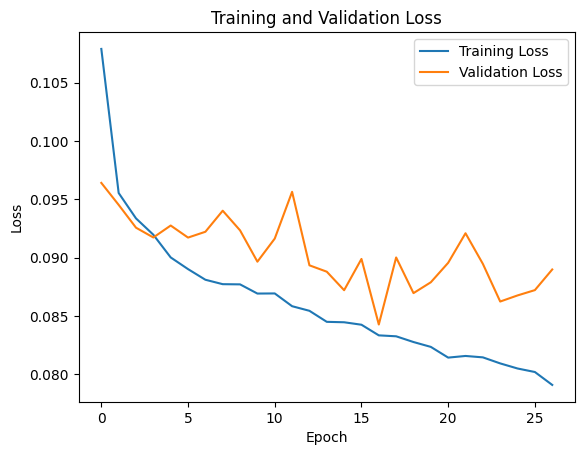

In [47]:
import matplotlib.pyplot as plt
import numpy as np

loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, train_loss_list, label='Training Loss')
plt.plot(loss, val_loss_list, label='Validation Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Draw chart for train dataset

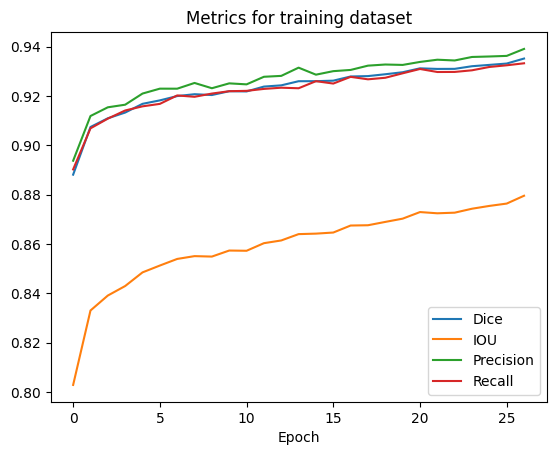

In [48]:
loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, train_dice_loss, label='Dice') 
plt.plot(loss, train_iou_loss, label='IOU') 
plt.plot(loss, train_precision_loss, label='Precision') 
plt.plot(loss, train_recall_loss, label='Recall') 
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics for training dataset')
plt.legend()
plt.show()


### Draw chart for validation dataset

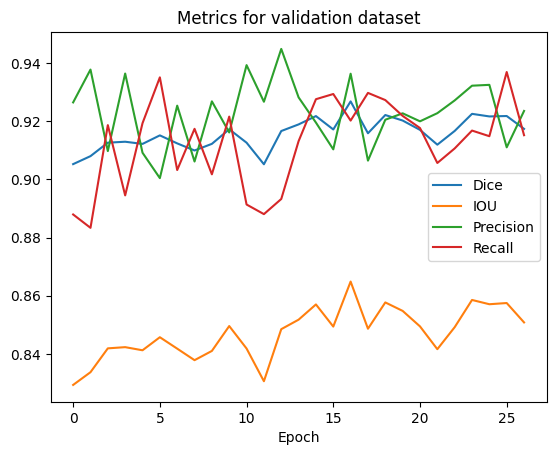

In [49]:
loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, val_dice_loss, label='Dice') 
plt.plot(loss, val_iou_loss, label='IOU') 
plt.plot(loss, val_precision_loss, label='Precision') 
plt.plot(loss, val_recall_loss, label='Recall') 
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics for validation dataset')
plt.legend()
plt.show()


### Đánh giá trọng số mô hình với tập Test Dataset (IOU, Precision, Recall, Dice)

In [50]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Tải trọng số từ checkpoint
checkpoint_path = "/kaggle/working/best_model_weights_SAM_jointloss.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load trọng số vào mô hình
model.load_state_dict(checkpoint)

# Đặt mô hình vào chế độ đánh giá
model.eval()

# Tiếp tục quá trình kiểm tra mô hình như đã thực hiện trước đó
test_dice_scores = []
test_iou_scores = []
test_recall_scores = []
test_precision_scores = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute evaluation metrics
        predicted_masks = (torch.sigmoid(outputs['pred_masks']).squeeze() > 0.5).float()
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        test_dice_scores.append(dice(predicted_masks, ground_truth_masks))
        test_iou_scores.append(iou(predicted_masks, ground_truth_masks))
        test_recall_scores.append(recall(predicted_masks, ground_truth_masks))
        test_precision_scores.append(precision(predicted_masks, ground_truth_masks))

# Print evaluation metrics
print("\n")
print(f'Test Dice: {torch.tensor(test_dice_scores).mean().item():.4f}')
print(f'Test IOU: {torch.tensor(test_iou_scores).mean().item():.4f}')
print(f'Test Recall: {torch.tensor(test_recall_scores).mean().item():.4f}')
print(f'Test Precision: {torch.tensor(test_precision_scores).mean().item():.4f}')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/best_model_weights_SAM_jointloss.pt'

### Train tiếp model từ trọng số

## Kiểm thử mô hình

In [ ]:
# import numpy as np
# from PIL import Image

# # let's take a random training example
# idx = 100

# # load image
# image = test_dataset[idx]["image"]
# image

In [ ]:
# import torch
# # Sử dụng GPU nếu có sẵn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # get box prompt based on ground truth segmentation map
# ground_truth_mask = np.array(test_dataset[idx]["label"])
# prompt = get_bounding_box(ground_truth_mask)

# # prepare image + box prompt for the model
# inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
# for k,v in inputs.items():
#   print(k,v.shape)

In [ ]:
# model.eval()

# # forward pass
# with torch.no_grad():
#   outputs = model(**inputs, multimask_output=False)

In [ ]:
# # apply sigmoid
# medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# # convert soft mask to hard mask
# medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
# medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)

In [ ]:
# import numpy as np
# from PIL import Image
# import torch
# import matplotlib.pyplot as plt

# # Sử dụng GPU nếu có sẵn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for idx in range(0, len(test_dataset)):  # Duyệt qua các chỉ số từ 1 đến 10
#     # load image
#     image = test_dataset[idx]["image"]

#     # get box prompt based on ground truth segmentation map
#     ground_truth_mask = np.array(test_dataset[idx]["label"])
#     prompt = get_bounding_box(ground_truth_mask)

#     # prepare image + box prompt for the model
#     inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

#     model.eval()

#     # forward pass
#     with torch.no_grad():
#         outputs = model(**inputs, multimask_output=False)

#     # apply sigmoid
#     medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
#     # convert soft mask to hard mask
#     medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
#     medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     # Hiển thị hình ảnh
#     axes[0].imshow(image)
#     axes[0].set_title("Image")
#     axes[0].axis("off")

#     # Hiển thị đồ thị cho ground truth mask
#     axes[1].imshow(ground_truth_mask)
#     axes[1].set_title("Ground truth mask")
#     axes[1].axis("off")

#     # Hiển thị đồ thị cho predicted mask
#     axes[2].imshow(medsam_seg)
#     axes[2].set_title("Predicted mask")
#     axes[2].axis("off")

#     plt.show()